In [95]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.feature_extraction import text
import nltk
import re
import math
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, confusion_matrix

# Supress warnings
"""
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
"""

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/christinefang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/christinefang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [97]:
df = pd.read_csv('../../../sample_events.csv')
df = df[["description", "relevant_event", "internal_conflict", "multiple_events", "naxalite_maoist"]]

df = df.drop_duplicates(subset=["description"]).dropna().reset_index(drop=True)
df["relevant_event"] = df["relevant_event"].replace(r'[2-9]{1,4}', np.nan, regex=True).fillna(0)
df["internal_conflict"] = df["internal_conflict"].replace(r'[2-9]{1,4}', np.nan, regex=True).fillna(0)
df["multiple_events"] = df["multiple_events"].replace(r'[2-9]{1,4}', np.nan, regex=True).fillna(0)
df["naxalite_maoist"] = df["naxalite_maoist"].replace(r'[2-9]{1,4}', np.nan, regex=True).fillna(0)

df.index = range(len(df))
df.head(10)

,description,relevant_event,internal_conflict,multiple_events,naxalite_maoist
0,Nagaland Post reports that a National Socialis...,1.0,1.0,0.0,0.0
1,"On February 22, Minister of State for Home, S....",0.0,0.0,0.0,0.0
2,Kanglaonline reports on June 21 that a militan...,1.0,1.0,0.0,0.0
3,Two security personnel were seriously injured ...,1.0,1.0,0.0,0.0
4,The Union Ministry of Home Affairs (UMHA) has ...,1.0,1.0,0.0,1.0
5,A woman Communist Party of India-Maoist (CPI-M...,1.0,1.0,0.0,1.0
6,Militants lobbed a hand grenade targeting comp...,1.0,1.0,0.0,0.0
7,Students under Kangleipak Students' Associatio...,1.0,1.0,0.0,0.0
8,"On May 5, an IED blast was reported in front o...",1.0,1.0,0.0,0.0
9,11 civilians were injured as unidentified terr...,1.0,1.0,0.0,0.0


# Cleaning and Tokenizing

In [98]:
data_stripped = []
data_tokenized_words = []

wl = WordNetLemmatizer()

for i in range(len(df)):
    # removes unnecessary characters
    row = re.sub('[^a-zA-Z0-9. ]', '', df['description'][i])
    row = row.lower()
    # tokenization
    row = row.split()
    # lemmatization and stop words removal
    row = [wl.lemmatize(word) for word in row if not word in set(stopwords.words('english'))]
    row2 = re.sub('[^a-zA-Z0-9 ]', '', ' '.join(row))
    row2 = row2.split(' ')
    row3 = ' '.join(row).split('.')
    
    
    data_stripped.append(' '.join(row))
    data_tokenized_words.append(row2)


df['stripped_description'] = data_stripped
df['word_tokenized_description'] = data_tokenized_words

In [100]:
# 5-Fold cross-validation
def cross_validation(Y, accuracy_metric, a):
    # Split dataset into folds
    kf = KFold(n_splits=5, shuffle=True)
    accuracy = []

    nb = MultinomialNB(alpha = a)
    vectorizer = text.TfidfVectorizer(analyzer=lambda x: x,)
    X = vectorizer.fit_transform(df["word_tokenized_description"])

    # Cross-validation
    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X[train_idx, :], X[valid_idx, :]
        Y_train, Y_valid = Y[train_idx], Y[valid_idx]
        nb.fit(X_train,Y_train)
        predictions = nb.predict(X_valid)
        accuracy.append(accuracy_metric(predictions, Y_valid))
    return np.mean(accuracy)

In [101]:
def precision_score_zero_div(predictions, Y_valid):
    return precision_score(predictions, Y_valid, zero_division=np.nan)

def recall_score_zero_div(predictions, Y_valid):
    return recall_score(predictions, Y_valid, zero_division=np.nan)

""" def accuracies(Y, alpha):
        accuracy_cv = pd.DataFrame(columns = ['folds', 'validation_acc', 'balanced_acc', 'precision', 'recall'])

        metrics = [accuracy_score, balanced_accuracy_score, precision_score_zero_div, recall_score_zero_div]

        for folds in range(5,21,5):
                accuracies = [folds]
                for i in range(len(metrics)):
                        mean_accuracy = cross_validation(folds, Y, metrics[i], alpha)
                        accuracies.append(mean_accuracy)
                accuracy_cv = pd.concat([pd.DataFrame([accuracies], columns=accuracy_cv.columns), accuracy_cv], ignore_index=True)

        accuracy_cv['folds'] = accuracy_cv['folds'].astype('int')
        accuracy_cv.set_index('folds')
        return accuracy_cv
"""

" def accuracies(Y, alpha):\n        accuracy_cv = pd.DataFrame(columns = ['folds', 'validation_acc', 'balanced_acc', 'precision', 'recall'])\n\n        metrics = [accuracy_score, balanced_accuracy_score, precision_score_zero_div, recall_score_zero_div]\n\n        for folds in range(5,21,5):\n                accuracies = [folds]\n                for i in range(len(metrics)):\n                        mean_accuracy = cross_validation(folds, Y, metrics[i], alpha)\n                        accuracies.append(mean_accuracy)\n                accuracy_cv = pd.concat([pd.DataFrame([accuracies], columns=accuracy_cv.columns), accuracy_cv], ignore_index=True)\n\n        accuracy_cv['folds'] = accuracy_cv['folds'].astype('int')\n        accuracy_cv.set_index('folds')\n        return accuracy_cv\n"

# Hyperparameter (alpha) tuning

In [102]:
def alpha_accuracies(col):
    accuracy = []
    balanced= []
    recall = []
    precision =  []

    metrics = [accuracy_score, balanced_accuracy_score, precision_score_zero_div, recall_score_zero_div]

    for i in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]:
        accuracies = []
        for j in range(len(metrics)):
            accuracies.append(cross_validation(col, metrics[j], i))
        accuracy.append(accuracies[0])
        balanced.append(accuracies[1])
        recall.append(accuracies[2])
        precision.append(accuracies[3])

    data = {'alpha_param': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10], 
            'accuracy_score': accuracy,
            'balanced_accuracy': balanced,
            'precision': precision,
            'recall': recall} 

    return data

def confusion_matrix_alpha(alpha_param, y, x):
    nb = MultinomialNB(alpha = alpha_param)
    idx = math.ceil(x.shape[0]*(4/5))
    x_train, x_valid = x[:idx], x[idx:]
    y_train, y_valid = y[:idx], y[idx:]
    nb.fit(x_train,y_train)
    pred = nb.predict(x_valid)

    cm = confusion_matrix(y_valid, pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'Blues', annot_kws = {'size': 16})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Alpha = {alpha_param}')



vectorizer = text.TfidfVectorizer(analyzer=lambda x: x,)
x = vectorizer.fit_transform(df["word_tokenized_description"])

## Relevant Event

In [103]:
data = alpha_accuracies(df["relevant_event"])
pd.DataFrame(data)

,alpha_param,accuracy_score,balanced_accuracy,precision,recall
0,0.00001,0.907527,0.775994,0.925031,0.990524
1,0.00010,0.905376,0.686537,0.934342,0.985740
2,0.00100,0.896774,0.662937,0.941936,0.950741
3,0.01000,0.860215,0.678017,0.961627,0.891399
4,0.10000,0.909677,0.743383,0.933868,0.974011
5,1.00000,0.913978,0.913978,0.913978,1.000000
6,10.00000,0.913978,0.913978,0.913978,1.000000


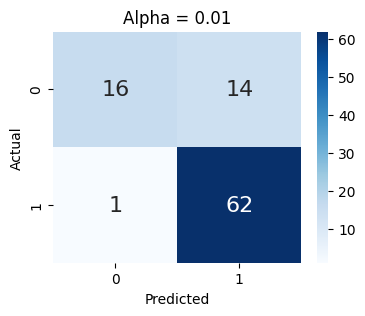

In [104]:
#Confusion matrix for alpha = 0.01
confusion_matrix_alpha(0.01, df["relevant_event"], x)

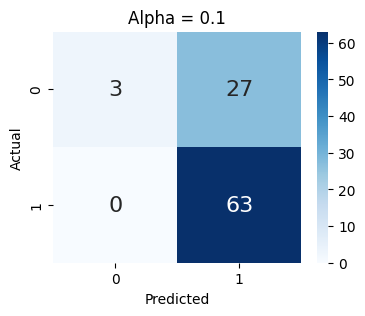

In [87]:
#Confusion matrix for alpha = 0.1
confusion_matrix_alpha(0.1, df["relevant_event"], x)

## Internal Conflict

In [105]:
data = alpha_accuracies(df["internal_conflict"])
pd.DataFrame(data)

,alpha_param,accuracy_score,balanced_accuracy,precision,recall
0,0.00001,0.883871,0.694908,0.900973,0.978623
1,0.00010,0.870968,0.679129,0.906134,0.968351
2,0.00100,0.883871,0.692748,0.921606,0.918496
3,0.01000,0.825806,0.616686,0.925514,0.878553
4,0.10000,0.883871,0.705665,0.912948,0.958395
5,1.00000,0.883871,0.883871,0.883871,1.000000
6,10.00000,0.883871,0.883871,0.883871,1.000000


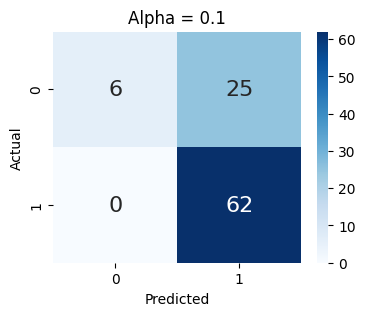

In [106]:
confusion_matrix_alpha(0.1, df["internal_conflict"], x)

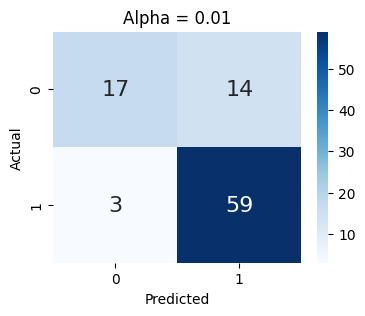

In [107]:
confusion_matrix_alpha(0.01, df["internal_conflict"], x)

## Multiple Events

In [112]:
data = alpha_accuracies(df["multiple_events"])
pd.DataFrame(data)

# Note: NaN means zero-division

,alpha_param,accuracy_score,balanced_accuracy,precision,recall
0,0.00001,0.894624,0.604845,0.133333,0.041667
1,0.00010,0.877419,0.595661,0.300000,0.134848
2,0.00100,0.853763,0.607505,0.167879,0.208889
3,0.01000,0.748387,0.540026,0.199385,0.395556
4,0.10000,0.877419,0.450412,0.100000,0.000000
5,1.00000,0.903226,0.903226,NaN,0.000000
6,10.00000,0.903226,0.903226,NaN,0.000000


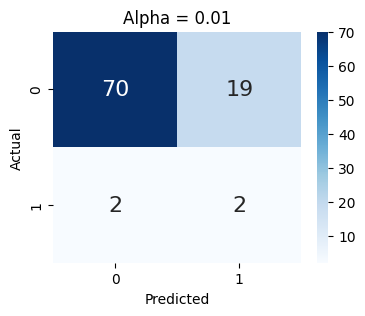

In [113]:
confusion_matrix_alpha(0.01, df["multiple_events"], x)

## Naxalite Maoist

In [114]:
data = alpha_accuracies(df["naxalite_maoist"])
pd.DataFrame(data)

,alpha_param,accuracy_score,balanced_accuracy,precision,recall
0,0.00001,0.860215,0.879104,0.828913,0.631356
1,0.00010,0.879570,0.860293,0.829220,0.707839
2,0.00100,0.888172,0.858482,0.828775,0.782749
3,0.01000,0.888172,0.860272,0.755894,0.851259
4,0.10000,0.903226,0.874039,0.825201,0.826639
5,1.00000,0.750538,0.811850,1.000000,0.138915
6,10.00000,0.722581,0.722581,NaN,0.000000


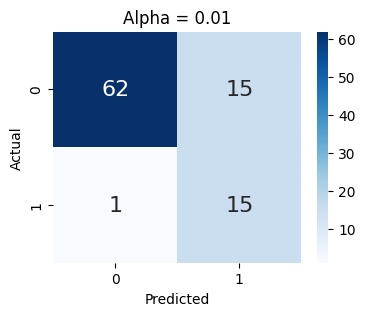

In [115]:
confusion_matrix_alpha(0.01, df["naxalite_maoist"], x)